<a href="https://colab.research.google.com/github/ilham-mukti/Machine-Learning/blob/main/Nyoba_3_XGBoost_Regresi_%5BData_Carprice%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install jcopml

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix

from skopt import BayesSearchCV
from xgboost import XGBRegressor, XGBClassifier

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.tuning import grid_search_params as gsp, random_search_params as rsp, bayes_search_params as bsp
from jcopml.feature_importance import mean_score_decrease, mean_loss_decrease
from jcopml.plot import plot_missing_value, plot_confusion_matrix, plot_correlation_matrix
from jcopml.tuning.space import Integer, Real

sns.set()

In [4]:
datas = pd.read_csv("/content/carprice.csv", index_col='ID')
datas.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage_kmpl,Engine_CC,Power_bhp,Seats,Price
ID,,,,,,,,,,,,
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,17.74
6,Nissan Micra Diesel XV,Jaipur,2013,86999,Diesel,Manual,First,23.08,1461.0,63.10,5.0,3.50


In [26]:
def encode_merk(x):
  return x.split()[0]

In [27]:
datas['Merk'] = datas.Name.apply(encode_merk)

In [29]:
X = datas.drop(columns=['Name', 'Price'])
y = datas.Price

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((4762, 11), (1191, 11))

In [36]:
param = {'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__max_depth': Integer(low=1, high=5),
 'algo__n_estimators': Integer(low=100, high=150),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform'),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform')}
 
 preprocessor = ColumnTransformer([
    ('categoric', cat_pipe(impute='most_frequent', encoder='onehot'), ['Location', 'Fuel_Type',
                                                                       'Transmission', 'Merk']),
    ('numeric', num_pipe(impute='median'), ['Power_bhp', 'Year','Engine_CC',
                                            'Kilometers_Driven', 'Mileage_kmpl',])
])
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])  

model = RandomizedSearchCV(pipeline, param, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)
model.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   26.8s finished


[10:15:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'algo__colsample_bytree': 0.8285509415257439,
 'algo__gamma': 4,
 'algo__learning_rate': 0.19513967655934458,
 'algo__max_depth': 4,
 'algo__n_estimators': 140,
 'algo__reg_alpha': 0.5804314717414071,
 'algo__reg_lambda': 0.03523233163198315,
 'algo__subsample': 0.7683649943683674}

In [37]:
 model.score(X_train, y_train), model.score(X_test, y_test)

(0.9853847478498629, 0.9052966683004188)

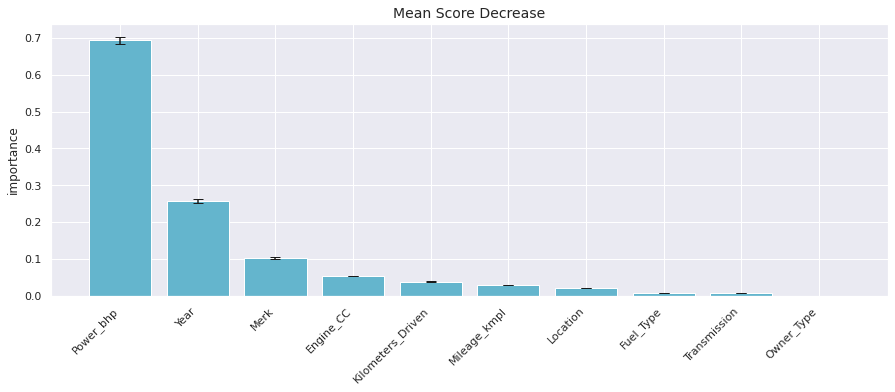

In [50]:
df_imp = mean_score_decrease(X_train, y_train, model, plot=True, topk=10)

In [52]:
list(df_imp.feature)

['Power_bhp',
 'Year',
 'Merk',
 'Engine_CC',
 'Kilometers_Driven',
 'Mileage_kmpl',
 'Location',
 'Fuel_Type',
 'Transmission',
 'Owner_Type']

In [ ]:
param = {'algo__colsample_bytree': Real(low=0.1, high=1, prior='uniform'),
 'algo__gamma': Integer(low=1, high=10),
 'algo__learning_rate': Real(low=-2, high=0, prior='log-uniform'),
 'algo__max_depth': Integer(low=1, high=5),
 'algo__n_estimators': Integer(low=100, high=150),
 'algo__reg_alpha': Real(low=-3, high=1, prior='log-uniform'),
 'algo__reg_lambda': Real(low=-3, high=1, prior='log-uniform'),
 'algo__subsample': Real(low=0.3, high=0.8, prior='uniform')}
 
preprocessor = ColumnTransformer([
    ('categoric', cat_pipe(impute='most_frequent', encoder='onehot'), ['Location', 'Merk']),
    ('numeric', num_pipe(impute='median'), ['Power_bhp', 'Year','Engine_CC',
                                            'Kilometers_Driven'])
])
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])  

model = BayesSearchCV(pipeline, bsp.xgb_params, cv=3, n_iter=50, n_jobs=-1, verbose=1, random_state=42)
model.fit(X_train, y_train)
model.best_params_

In [54]:
 model.score(X_train, y_train), model.score(X_test, y_test)

(0.9638699278039046, 0.889820187960227)